In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import plotly.graph_objects as go
import os
import sys  

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import tf_neuralnetwork as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
VOL = '/mnt/data1/stock/mlsoundings/results'

In [63]:
X = np.linspace(0, 5, 20)
T = np.sin(X)

In [64]:
from sklearn.isotonic import IsotonicRegression
# iso_reg = IsotonicRegression().fit(rap[0,:,-1], raob[0,:,1])
# iso_reg.predict(rap[0,:,1])

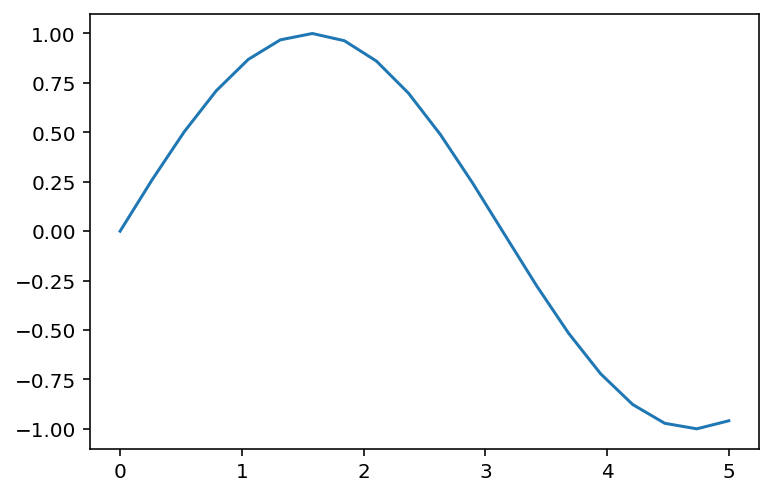

In [65]:
plt.plot(X, T)

## Baseline Metrics

In [89]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

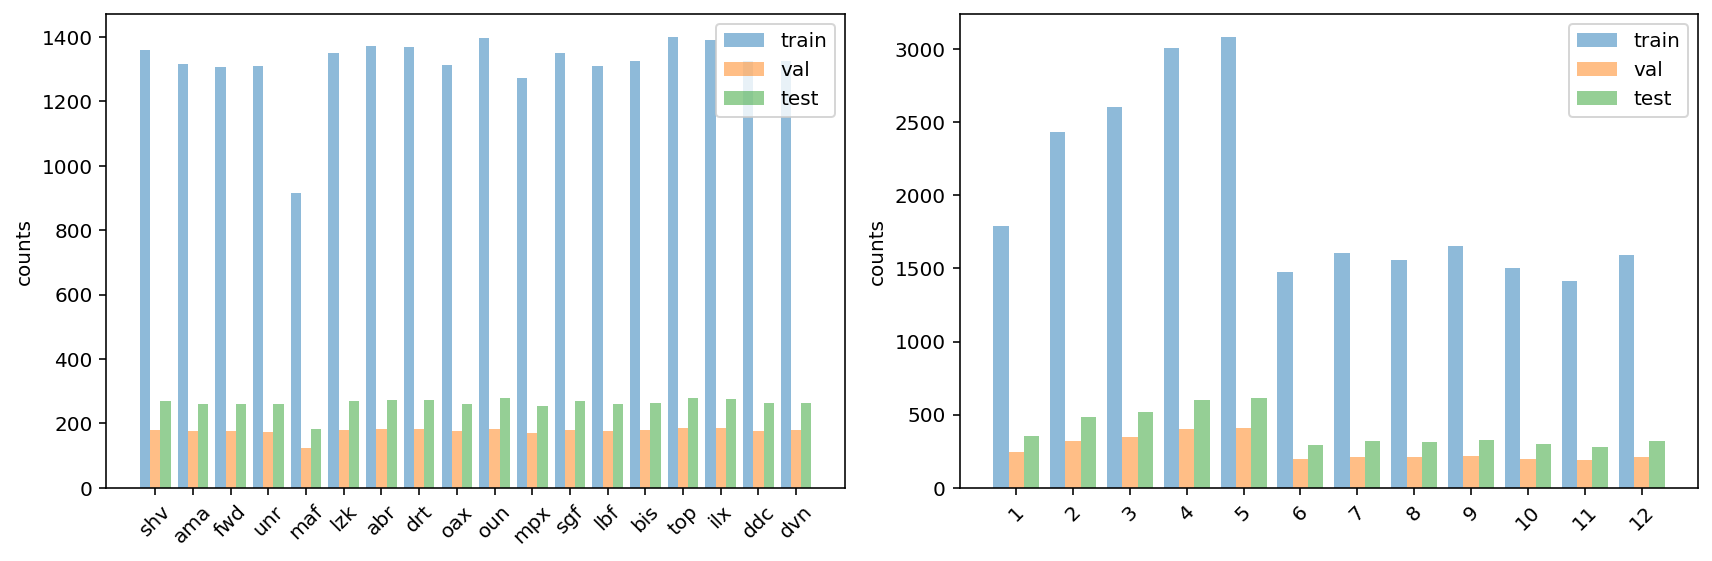

In [90]:
locations = {'bis', 'abr', 'unr', 'lbf', 'oax', 'top',
             'ddc', 'oun', 'ama', 'fwd', 'maf', 'drt',
             'lzk', 'sgf', 'shv', 'dvn', 'ilx', 'mpx'} # 'sgp'
l_ind = np.arange(len(locations))
months = np.arange(1, 13)

width = 0.27 # the width of the bars

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

FILEtrain_content = np.array([f.split('_') for f in FILEtrain])
FILEval_content   = np.array([f.split('_') for f in FILEval])
FILEtest_content  = np.array([f.split('_') for f in FILEtest])

_, counts = np.unique(FILEtrain_content[:,0], return_counts=True)
rects1 = axs[0].bar(l_ind, counts, width, alpha=0.5)
_, counts = np.unique(FILEval_content[:,0], return_counts=True)
rects2 = axs[0].bar(l_ind+width, counts, width, alpha=0.5)
_, counts = np.unique(FILEtest_content[:,0], return_counts=True)
rects3 = axs[0].bar(l_ind+width*2, counts, width, alpha=0.5)

axs[0].set_ylabel('counts')
axs[0].set_xticks(l_ind+width)
axs[0].set_xticklabels(locations, rotation=45)
axs[0].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

_, counts = np.unique(pd.to_datetime(FILEtrain_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects1 = axs[1].bar(months, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEval_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects2 = axs[1].bar(months+width, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEtest_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects3 = axs[1].bar(months+width*2, counts, width, alpha=0.5)

axs[1].set_ylabel('counts')
axs[1].set_xticks(months+width)
axs[1].set_xticklabels(months, rotation=45)
axs[1].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

fig.tight_layout()

In [66]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [67]:
def min_max(df):
    min_i = np.inf
    min_v = np.inf
    max_i = 0
    max_v = 0
    for i, row in df.iterrows():
        train_rmse = np.asarray(literal_eval(row[f'root_mean_squared_error']))
        if train_rmse.min() < min_v:
            min_v = train_rmse.min()
            min_i = i
        if train_rmse.max() > max_v:
            max_v = train_rmse.max()
            max_i = i  

        plt.plot(train_rmse)
        plt.plot(np.asarray(literal_eval(row[f'val_root_mean_squared_error'])),'--')

    return min_i, min_v, max_i, max_v

In [91]:
1e-5 == 0.00001

True

# Linear

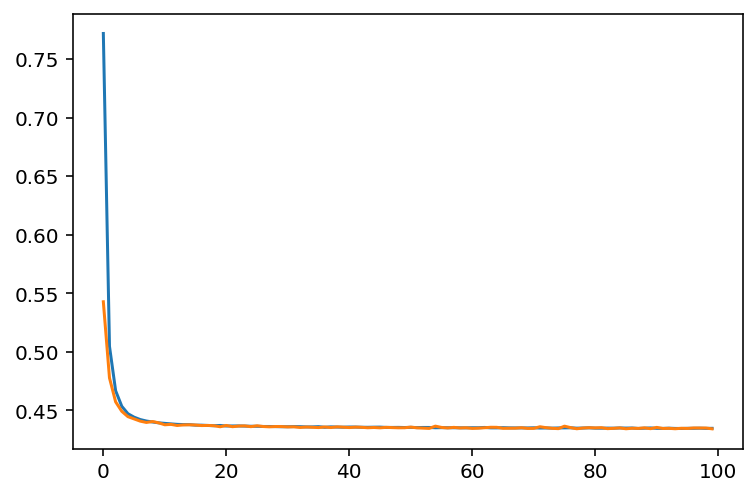

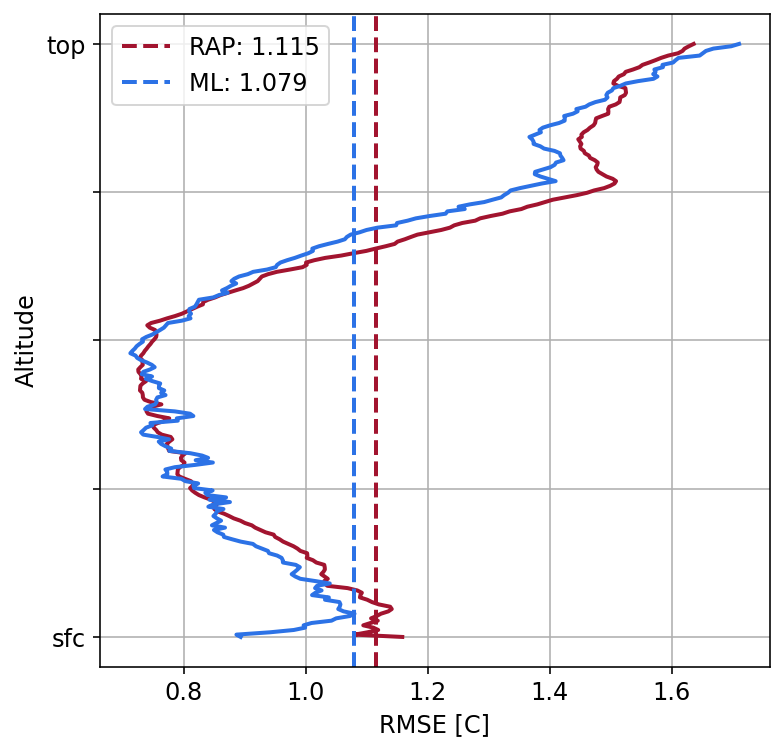

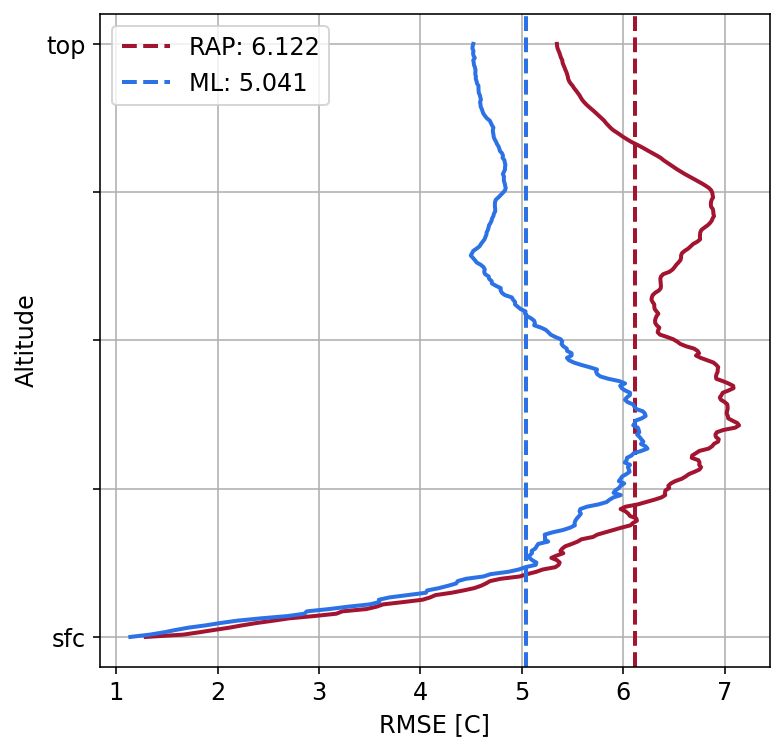

In [68]:
df = pd.read_csv(os.path.join(VOL, 'alley_linear_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [69]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

rap_input_dims rap_output_dims rtma_input_channels  \
9    [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
12   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
8    [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
13   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
1    [0, 1, 2, 3]          [1, 2]                  []   

         goes_input_channels  n_network_inputs hiddens  n_network_outputs  \
9                         []              1051     [0]                512   
12  [0, 1, 2, 3, 4, 5, 6, 7]              1123     [0]                512   
8                         []              1051     [0]                512   
13  [0, 1, 2, 3, 4, 5, 6, 7]              1123     [0]                512   
1                         []              1024     [0]                512   

   optim      lr activ loss_f  n_epochs  batch_size  batchnorm  dropout  \
9   adam  0.0001  None    MAE       100         128      False    False   
12  adam  0.0001  None    MSE       100         128      False    False   
8   adam  0.0001  None    MSE       100         128      False    False   
13  adam  0.0001  None    MAE       100         128      False    False   
1   adam  0.0001  None    MAE       100         128      False    False   

                                                 loss  \
9   [0.5469719171524048, 0.341694176197052, 0.2997...   
12  [0.5886015295982361, 0.27318182587623596, 0.22...   
8   [0.6321904063224792, 0.28879112005233765, 0.24...   
13  [0.5370222330093384, 0.33421120047569275, 0.29...   
1   [0.5460024476051331, 0.34342658519744873, 0.30...   

                              root_mean_squared_error  \
9   [0.7718355655670166, 0.5047458410263062, 0.466...   
12  [0.767203688621521, 0.5226680040359497, 0.4781...   
8   [0.7951040267944336, 0.5373929142951965, 0.490...   
13  [0.7563784122467041, 0.493228942155838, 0.4574...   
1   [0.7638912200927734, 0.506691575050354, 0.4685...   

                                   mean_squared_error  \
9   [0.5957301259040833, 0.25476837158203125, 0.21...   
12  [0.5886015295982361, 0.27318182587623596, 0.22...   
8   [0.6321904063224792, 0.28879112005233765, 0.24...   
13  [0.572108268737793, 0.2432747781276703, 0.2092...   
1   [0.5835297703742981, 0.2567363679409027, 0.219...   

                                  mean_absolute_error  \
9   [0.5469719171524048, 0.341694176197052, 0.2997...   
12  [0.5555232763290405, 0.3707330524921417, 0.326...   
8   [0.5743953585624695, 0.3815169632434845, 0.335...   
13  [0.5370222330093384, 0.33421120047569275, 0.29...   
1   [0.5460024476051331, 0.34342658519744873, 0.30...   

                                             val_loss  \
9   [0.3818355202674866, 0.3141231834888458, 0.289...   
12  [0.3160831034183502, 0.24409620463848114, 0.21...   
8   [0.3347545564174652, 0.255804181098938, 0.2275...   
13  [0.3734462559223175, 0.30815690755844116, 0.28...   
1   [0.3838856816291809, 0.31571680307388306, 0.29...   

                          val_root_mean_squared_error  \
9   [0.5427995324134827, 0.47778233885765076, 0.45...   
12  [0.5622127056121826, 0.4940609335899353, 0.468...   
8   [0.5785797834396362, 0.5057708621025085, 0.477...   
13  [0.5302037000656128, 0.4682804048061371, 0.449...   
1   [0.5448781847953796, 0.478568971157074, 0.4588...   

                               val_mean_squared_error  \
9   [0.29463130235671997, 0.22827598452568054, 0.2...   
12  [0.3160831034183502, 0.24409620463848114, 0.21...   
8   [0.3347545564174652, 0.255804181098938, 0.2275...   
13  [0.28111597895622253, 0.21928653120994568, 0.2...   
1   [0.2968922555446625, 0.22902825474739075, 0.21...   

                              val_mean_absolute_error  \
9   [0.3818355202674866, 0.3141231834888458, 0.289...   
12  [0.4091085195541382, 0.343331515789032, 0.3167...   
8   [0.42129290103912354, 0.3521815538406372, 0.32...   
13  [0.3734462559223175, 0.30815690755844116, 0.28...   
1   [0.3838856816291809, 0.31571680307388306, 0.29...   

  

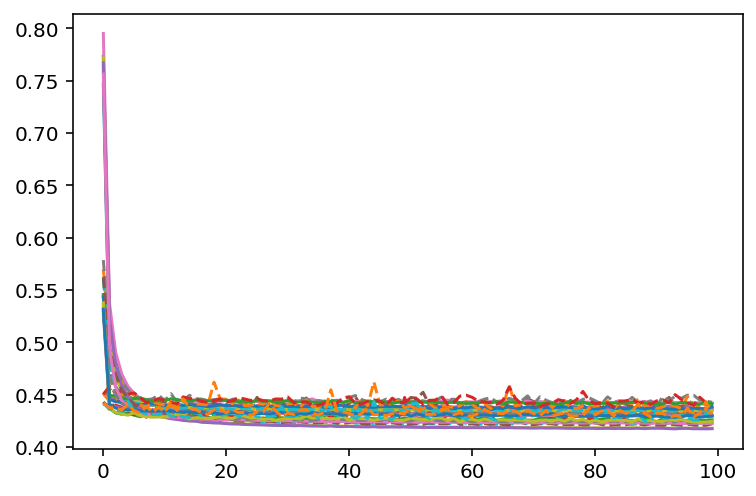

In [70]:
min_i, min_v, max_i, max_v = min_max(df)

# Fully Connected

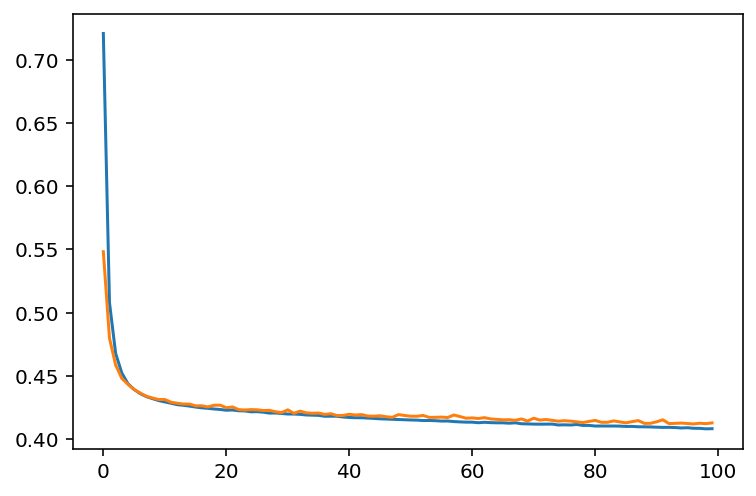

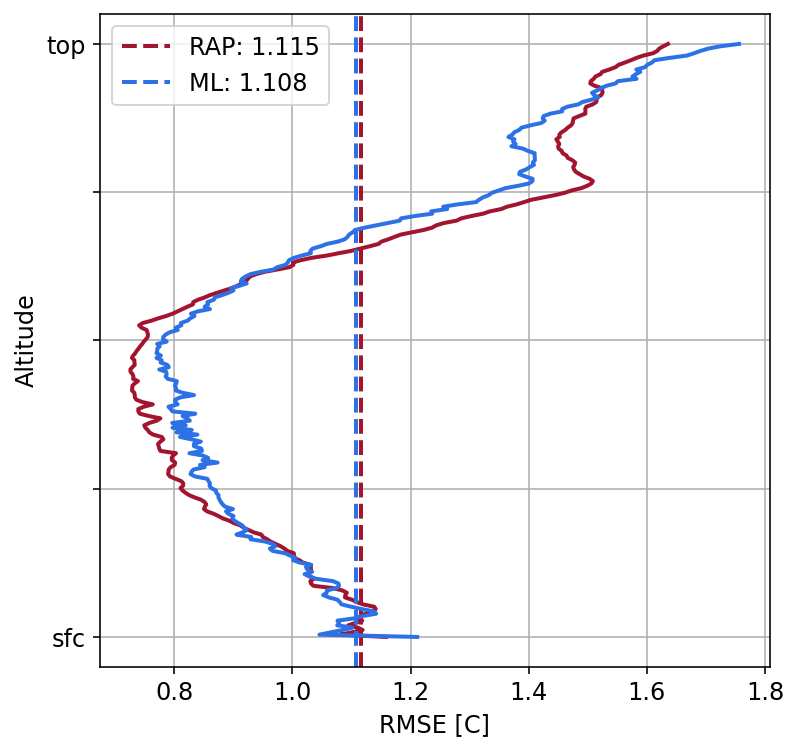

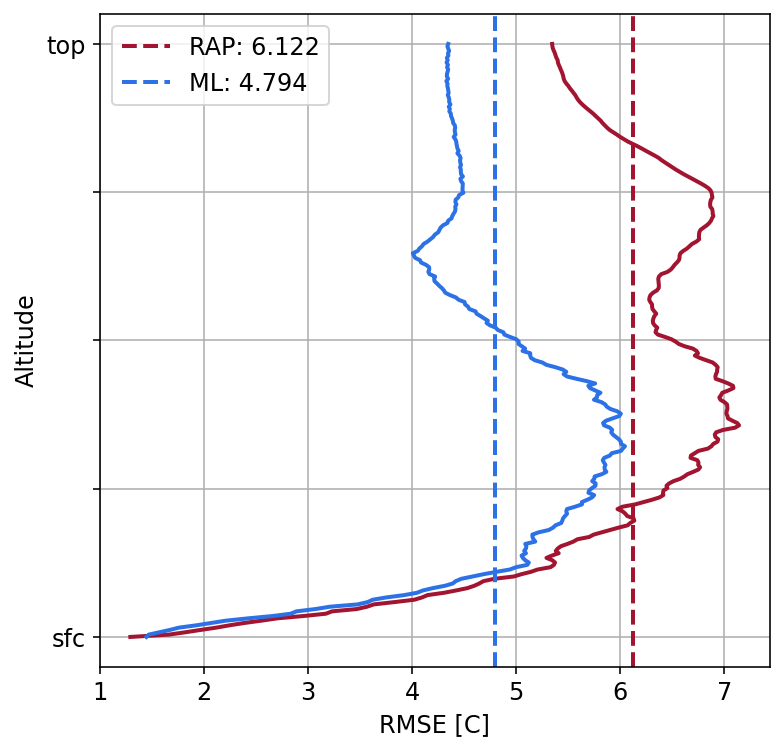

In [71]:
df = pd.read_csv(os.path.join(VOL, 'alley_fully_connected_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [72]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

rap_input_dims rap_output_dims rtma_input_channels  \
74    [0, 1, 2, 3]          [1, 2]                  []   
118   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
154   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
158   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
115   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   

          goes_input_channels  n_network_inputs hiddens  n_network_outputs  \
74   [0, 1, 2, 3, 4, 5, 6, 7]              1096   [256]                512   
118                        []              1051   [256]                512   
154  [0, 1, 2, 3, 4, 5, 6, 7]              1123   [256]                512   
158  [0, 1, 2, 3, 4, 5, 6, 7]              1123   [256]                512   
115                        []              1051   [256]                512   

    optim      lr activ loss_f  n_epochs  batch_size  batchnorm  dropout  \
74   adam  0.0001  tanh    MAE       100         128      False    False   
118  adam  0.0001  relu    MAE       100         128      False    False   
154  adam  0.0001  tanh    MAE       100         128      False    False   
158  adam  0.0001  relu    MAE       100         128      False    False   
115  adam  0.0001  tanh    MAE       100         128      False     True   

                                                  loss  \
74   [0.5316904783248901, 0.34916096925735474, 0.30...   
118  [0.5628003478050232, 0.3746283948421478, 0.328...   
154  [0.5416682958602905, 0.3522081971168518, 0.308...   
158  [0.5730842351913452, 0.3753720819950104, 0.327...   
115  [0.5820792317390442, 0.4014382064342499, 0.357...   

                               root_mean_squared_error  \
74   [0.7206183671951294, 0.5078155398368835, 0.467...   
118  [0.7666160464286804, 0.53980952501297, 0.49240...   
154  [0.7337679266929626, 0.5117250680923462, 0.469...   
158  [0.7793694734573364, 0.5367990732192993, 0.487...   
115  [0.7760263681411743, 0.5594428777694702, 0.513...   

                                    mean_squared_error  \
74   [0.5192908644676208, 0.25787660479545593, 0.21...   
118  [0.5877000689506531, 0.29139429330825806, 0.24...   
154  [0.5384153723716736, 0.26186254620552063, 0.22...   
158  [0.6074168086051941, 0.2881532311439514, 0.237...   
115  [0.6022169589996338, 0.31297633051872253, 0.26...   

                                   mean_absolute_error  \
74   [0.5316904783248901, 0.34916096925735474, 0.30...   
118  [0.5628003478050232, 0.3746283948421478, 0.328...   
154  [0.5416682958602905, 0.3522081971168518, 0.308...   
158  [0.5730842351913452, 0.3753720819950104, 0.327...   
115  [0.5820792317390442, 0.4014382064342499, 0.357...   

                                              val_loss  \
74   [0.39046764373779297, 0.3210875988006592, 0.29...   
118  [0.41838717460632324, 0.3448774218559265, 0.31...   
154  [0.39404597878456116, 0.3230268359184265, 0.29...   
158  [0.4198480546474457, 0.3443433344364166, 0.315...   
115  [0.39816340804100037, 0.3281034827232361, 0.30...   

                           val_root_mean_squared_error  \
74   [0.5480954051017761, 0.47968965768814087, 0.45...   
118  [0.5842502117156982, 0.5071114301681519, 0.479...   
154  [0.5525506734848022, 0.4824666976928711, 0.460...   
158  [0.5827000141143799, 0.5040094256401062, 0.475...   
115  [0.5570576190948486, 0.4879101812839508, 0.467...   

                                val_mean_squared_error  \
74   [0.30040860176086426, 0.23010218143463135, 0.2...   
118  [0.341348260641098, 0.2571620047092438, 0.2303...   
154  [0.3053121864795685, 0.23277412354946136, 0.21...   
158  [0.3395393192768097, 0.25402548909187317, 0.22...   
115  [0.3103131949901581, 0.23805631697177887, 0.21...   

                               val_mean_absolute_error  \
74   [0.39046764373779297, 0.3210875988006592, 0.29...   
118  [0.41838717460632324, 0.3448774218559265, 0.31...   
154  [0.39404597878456116, 0.3230268359184265, 0.29...   
158  [0.4198480546474457, 0.3443433344364166, 0.315...

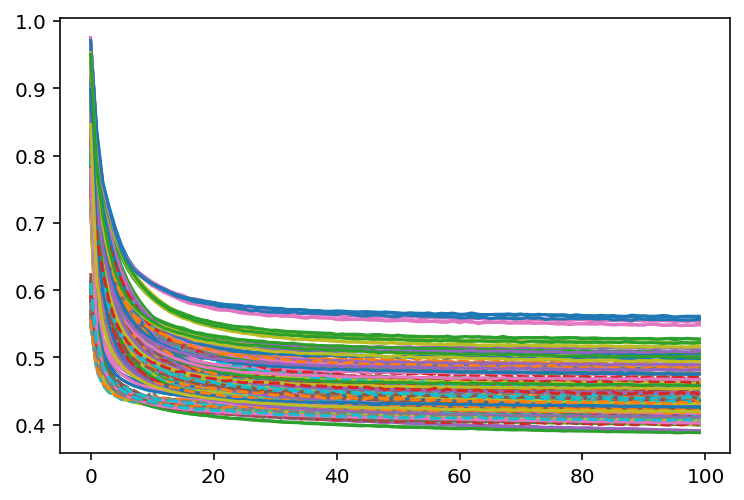

In [73]:
min_i, min_v, max_i, max_v = min_max(df)

# Convolutional

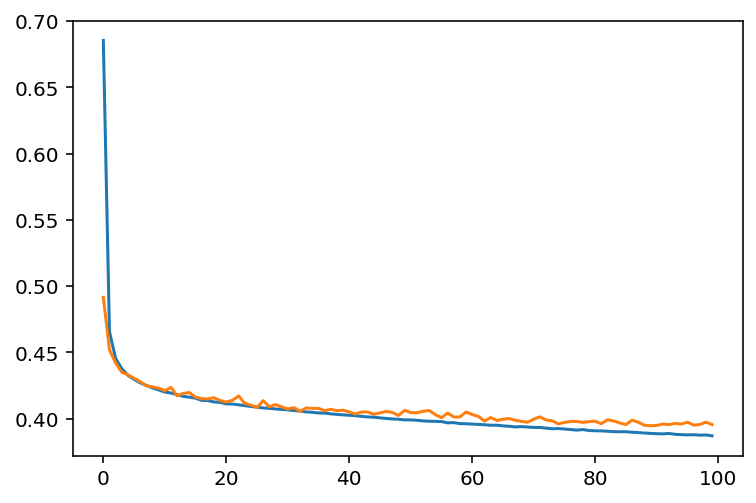

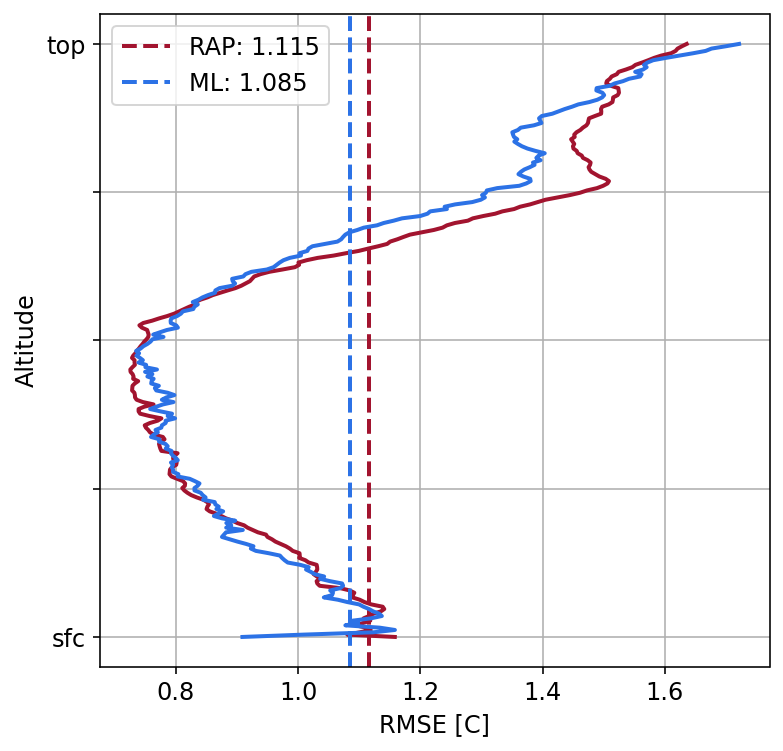

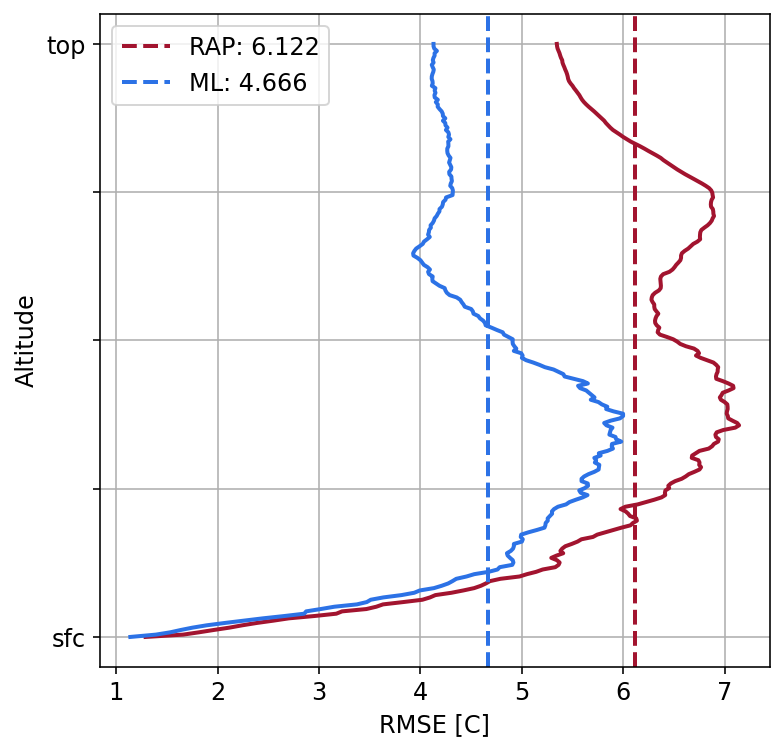

In [74]:
df = pd.read_csv(os.path.join(VOL, 'alley_multi_cnn_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [75]:
sorted_df = df.sort_values(['ml_temperature_test_mean_rmse'])
sorted_df.head()

rap_input_dims rap_output_dims rtma_input_channels  \
70   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
52   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
71   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
17   [0, 1, 2, 3]          [1, 2]                  []   
16   [0, 1, 2, 3]          [1, 2]                  []   

         goes_input_channels n_rap_inputs n_im_inputs hiddens  \
70  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
52                        []     (256, 4)   (3, 3, 3)      []   
71  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
17                        []     (256, 4)         NaN      []   
16                        []     (256, 4)         NaN      []   

    n_network_outputs   n_units_in_conv_layers kernels_size_and_stride  \
70                512  [32, 64, 128, 256, 256]                  (3, 1)   
52                512  [32, 64, 128, 256, 256]                  (3, 1)   
71                512  [32, 64, 128, 256, 256]                  (3, 1)   
17                512  [32, 64, 128, 256, 256]                  (3, 1)   
16                512  [32, 64, 128, 256, 256]                  (3, 1)   

   rap_activation dense_activation optim      lr loss_f  n_epochs  batch_size  \
70           relu             relu  adam  0.0001    MAE       100         128   
52           relu             relu  adam  0.0001    MAE       100         128   
71           relu             relu  adam  0.0001    MAE       100         128   
17           relu             relu  adam  0.0001    MAE       100         128   
16           relu             relu  adam  0.0001    MAE       100         128   

    batchnorm  dropout                                               loss  \
70      False    False  [0.49188902974128723, 0.3046101927757263, 0.28...   
52      False    False  [0.5019845366477966, 0.30916446447372437, 0.28...   
71      False     True  [0.5533820986747742, 0.39244481921195984, 0.35...   
17      False     True  [0.5347425937652588, 0.3678363561630249, 0.335...   
16      False    False  [0.4870344400405884, 0.3079952597618103, 0.288...   

                              root_mean_squared_error  \
70  [0.6853330731391907, 0.4654504656791687, 0.445...   
52  [0.6940922737121582, 0.47252288460731506, 0.45...   
71  [0.7401480674743652, 0.5459088087081909, 0.507...   
17  [0.7233457565307617, 0.527938723564148, 0.4941...   
16  [0.6772046089172363, 0.47394245862960815, 0.45...   

                                   mean_squared_error  \
70  [0.46968144178390503, 0.21664412319660187, 0.1...   
52  [0.4817640781402588, 0.22327788174152374, 0.20...   
71  [0.547819197177887, 0.29801639914512634, 0.257...   
17  [0.5232290625572205, 0.2787192761898041, 0.244...   
16  [0.4586060643196106, 0.22462143003940582, 0.20...   

                                  mean_absolute_error  \
70  [0.49188902974128723, 0.3046101927757263, 0.28...   
52  [0.5019845366477966, 0.30916446447372437, 0.28...   
71  [0.5533820986747742, 0.39244481921195984, 0.35...   
17  [0.5347425937652588, 0.3678363561630249, 0.335...   
16  [0.4870344400405884, 0.3079952597618103, 0.288...   

                                             val_loss  \
70  [0.33243462443351746, 0.29049795866012573, 0.2...   
52  [0.3359317183494568, 0.2933026850223541, 0.281...   
71  [0.36129462718963623, 0.3101687729358673, 0.29...   
17  [0.3606075942516327, 0.31425759196281433, 0.29...   
16  [0.32989105582237244, 0.29559189081192017, 0.2...   

                          val_root_mean_squared_error  \
70  [0.49151310324668884, 0.45177164673805237, 0.4...   
52  [0.4959695041179657, 0.4571700692176819, 0.446...   
71  [0.5195751786231995, 0.4660656750202179, 0.450...   
17  [0.5240947604179382, 0.4770843982696533, 0.460...   
16  [0.4930892288684845, 0.4582168161869049, 0.450...   

                               val_mean_squared_error  \
70  [0.2415851652622223, 0.20409758388996124, 0.19...   
52  [0.245985746383667, 0.2090044617652893, 0

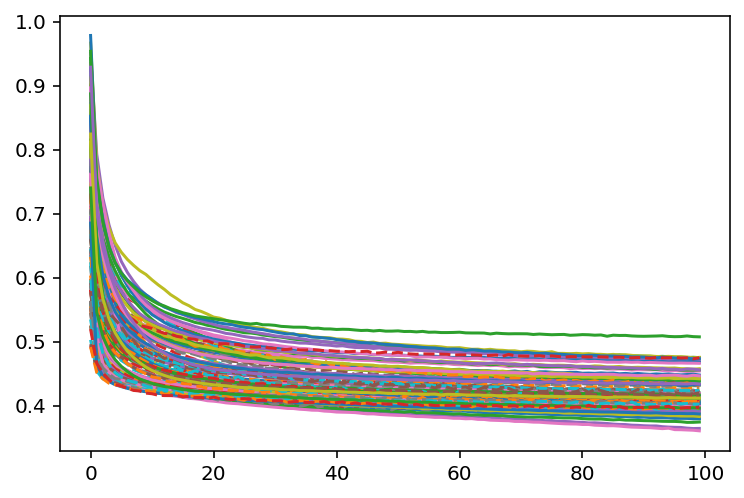

In [76]:
min_i, min_v, max_i, max_v = min_max(df)

rap_input_dims rap_output_dims rtma_input_channels  \
58   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
59   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   

         goes_input_channels n_rap_inputs n_im_inputs     hiddens  \
58  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)  [512, 256]   
59  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)  [512, 256]   

    n_network_outputs   n_units_in_conv_layers kernels_size_and_stride  \
58                512  [32, 64, 128, 256, 256]                  (3, 1)   
59                512  [32, 64, 128, 256, 256]                  (3, 1)   

   rap_activation dense_activation optim      lr loss_f  n_epochs  batch_size  \
58           relu             relu  adam  0.0001    MAE       100         128   
59           relu             relu  adam  0.0001    MAE       100         128   

    batchnorm  dropout                                               loss  \
58      False    False  [0.5638174414634705, 0.345003217458725, 0.3067...   
59      False     True  [0.671593427658081, 0.5181151032447815, 0.4643...   

                              root_mean_squared_error  \
58  [0.7618777751922607, 0.507339596748352, 0.4685...   
59  [0.8694668412208557, 0.6912950873374939, 0.629...   

                                   mean_squared_error  \
58  [0.5804577469825745, 0.257393479347229, 0.2195...   
59  [0.7559726238250732, 0.47788891196250916, 0.39...   

                                  mean_absolute_error  \
58  [0.5638174414634705, 0.345003217458725, 0.3067...   
59  [0.671593427658081, 0.5181151032447815, 0.4643...   

                                             val_loss  \
58  [0.39068710803985596, 0.31868937611579895, 0.2...   
59  [0.49704036116600037, 0.42451176047325134, 0.3...   

                          val_root_mean_squared_error  \
58  [0.5528957843780518, 0.4795001447200775, 0.460...   
59  [0.6684772968292236, 0.5891221165657043, 0.554...   

                               val_mean_squared_error  \
58  [0.30569374561309814, 0.2299203723669052, 0.21...   
59  [0.44686195254325867, 0.34706488251686096, 0.3...   

                              val_mean_absolute_error  \
58  [0.39068710803985596, 0.31868937611579895, 0.2...   
59  [0.49704036116600037, 0.42451176047325134, 0.3...   

                            ml_temperature_train_rmse  \
58  [1.0375485415302195, 1.0724893293737727, 1.167...   
59  [3.401906279477909, 2.7633046527719394, 2.5182...   

    ml_temperature_train_mean_rmse  \
58                        1.055256   
59                        1.318134   

                        ml_temperature_train_rmse_sfc  \
58  [1.0375485415302195, 1.0724893293737727, 1.167...   
59  [3.401906279477909, 2.7633046527719394, 2.5182...   

    ml_temperature_train_mean_rmse_sfc  \
58                            1.142524   
59                            1.995080   

                               ml_dewpoint_train_rmse  \
58  [1.248201966842099, 1.3743433953409838, 1.4544...   
59  [2.4011405973576743, 2.449906392591569, 2.4722...   

    ml_dewpoint_train_mean_rmse  \
58                     4.290651   
59                     4.798620   

                           ml_dewpoint_train_rmse_sfc  \
58  [1.248201966842099, 1.3743433953409838, 1.4544...   
59  [2.4011405973576743, 2.449906392591569, 2.4722...   

    ml_dewpoint_train_mean_rmse_sfc  \
58                         3.052719   
59                         3.862216   

                              ml_temperature_val_rmse  \
58  [1.0318362157949514, 1.0854266376393384, 1.181...   
59  [3.4152482888548885, 2.763355615205876, 2.5283...   

    ml_temperature_val_mean_rmse  \
58                      1.118496   
59                      1.366724   

                          ml_temperature_val_rmse_sfc  \
58  [1.0318362157949514, 1.0854266376393384, 1.181...   
59  [3.4152482888548885, 2.763355615205876, 2.5283...   

    ml_temperature_val_mean_rmse_sfc  \
58                          1.169773   
59                          2.022

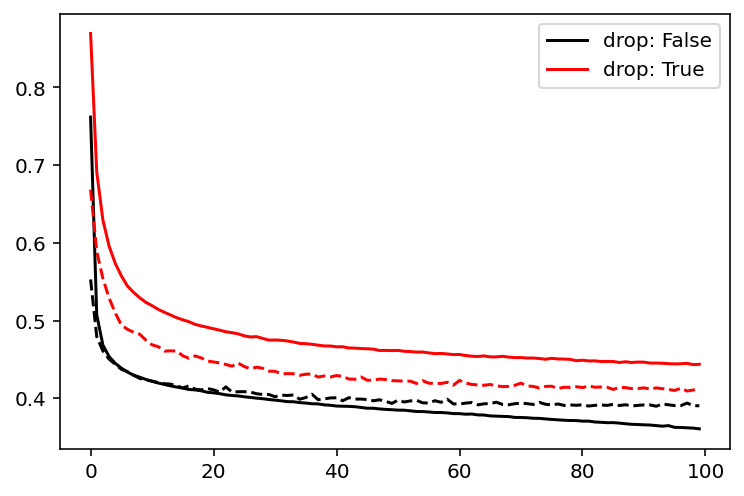

In [77]:
# get same models following first 16 params
filtered_df = df
for k, v in zip(df.iloc[min_i][:17].keys(), df.iloc[min_i][:17].values):
    filtered_df = filtered_df[filtered_df[k] == v]
    
#######

plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'root_mean_squared_error'])), color='k',
         label=f"drop: {filtered_df.iloc[0]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'val_root_mean_squared_error'])), '--k')

plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'root_mean_squared_error'])), color='r',
         label=f"drop: {filtered_df.iloc[1]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'val_root_mean_squared_error'])), '--r')

plt.legend()
filtered_df

rap_input_dims rap_output_dims rtma_input_channels  \
0   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   

        goes_input_channels n_rap_inputs n_im_inputs hiddens  \
0  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   

   n_network_outputs        n_units_in_conv_layers kernels_size_and_stride  \
0                512  [32, 64, 128, 128, 128, 128]                  (3, 1)   

  rap_activation dense_activation optim      lr loss_f  n_epochs  batch_size  \
0           relu             relu  adam  0.0001    MAE       100         128   

   batchnorm  dropout                                               loss  \
0      False     True  [0.5022448301315308, 0.3622158169746399, 0.315...   

                             root_mean_squared_error  \
0  [0.6808104515075684, 0.5111223459243774, 0.464...   

                                  mean_squared_error  \
0  [0.4635028839111328, 0.2612460255622864, 0.216...   

                                 mean_absolute_error  \
0  [0.5022448301315308, 0.3622158169746399, 0.315...   

                                            val_loss  \
0  [0.30514031648635864, 0.27240654826164246, 0.2...   

                         val_root_mean_squared_error  \
0  [0.4556020498275757, 0.42055872082710266, 0.41...   

                              val_mean_squared_error  \
0  [0.20757323503494263, 0.17686964571475983, 0.1...   

                             val_mean_absolute_error  \
0  [0.30514031648635864, 0.27240654826164246, 0.2...   

                           ml_temperature_train_rmse  \
0  [1.3806566985594146, 1.2588919591843808, 1.313...   

   ml_temperature_train_mean_rmse  \
0                        1.141013   

                       ml_temperature_train_rmse_sfc  \
0  [1.3806566985594146, 1.2588919591843808, 1.313...   

   ml_temperature_train_mean_rmse_sfc  \
0                            1.151217   

                              ml_dewpoint_train_rmse  \
0  [1.5006757415831309, 1.6391040332931504, 1.702...   

   ml_dewpoint_train_mean_rmse  \
0                     4.512691   

                          ml_dewpoint_train_rmse_sfc  \
0  [1.5006757415831309, 1.6391040332931504, 1.702...   

   ml_dewpoint_train_mean_rmse_sfc  \
0                         3.327699   

                             ml_temperature_val_rmse  \
0  [1.2773098194627504, 1.2465013391943789, 1.286...   

   ml_temperature_val_mean_rmse  \
0                      1.118213   

                         ml_temperature_val_rmse_sfc  \
0  [1.2773098194627504, 1.2465013391943789, 1.286...   

   ml_temperature_val_mean_rmse_sfc  \
0                           1.17442   

                                ml_dewpoint_val_rmse  \
0  [1.5754778722019647, 1.612088918809939, 1.7009...   

   ml_dewpoint_val_mean_rmse  \
0                   4.643323   

                            ml_dewpoint_val_rmse_sfc  \
0  [1.5754778722019647, 1.612088918809939, 1.7009...   

   ml_dewpoint_val_mean_rmse_sfc  \
0                       3.322503   

                            ml_temperature_test_rmse  \
0  [1.5876472080601496, 1.6611661202437917, 1.783...   

   ml_temperature_test_mean_rmse  \
0                       1.150549   

                        ml_temperature_test_rmse_sfc  \
0  [1.5876472080601496, 1.6611661202437917, 1.783...   

   ml_temperature_test_mean_rmse_sfc  \
0                           1.460479   

                               ml_dewpoint_test_rmse  \
0  [1.750244760358427, 1.8203939347563836, 2.0450...   

   ml_dewpoint_test_mean_rmse  \
0                    4.693368   

                           ml_dewpoint_test_rmse_sfc  \
0  [1.750244760358427, 1.8203939347563836, 2.0450...   

   ml_dewpoint_test_mean_rmse_sfc  
0                        3.299503

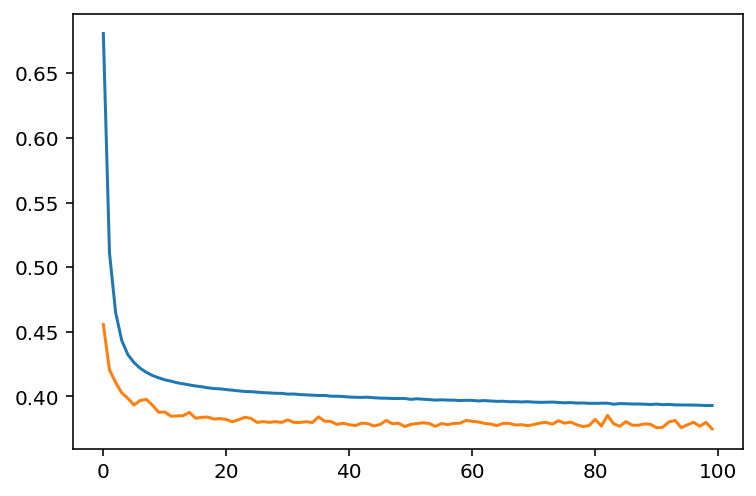

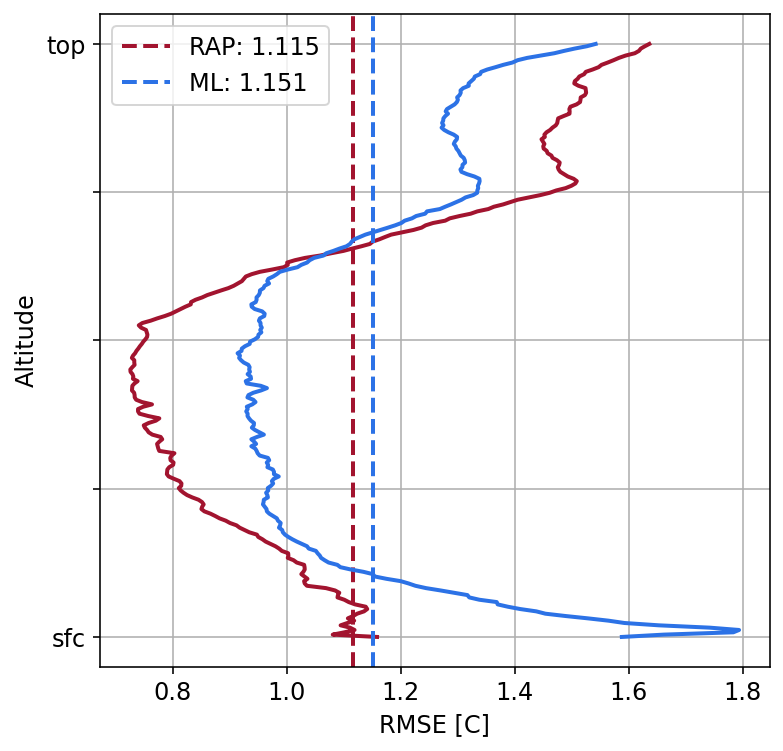

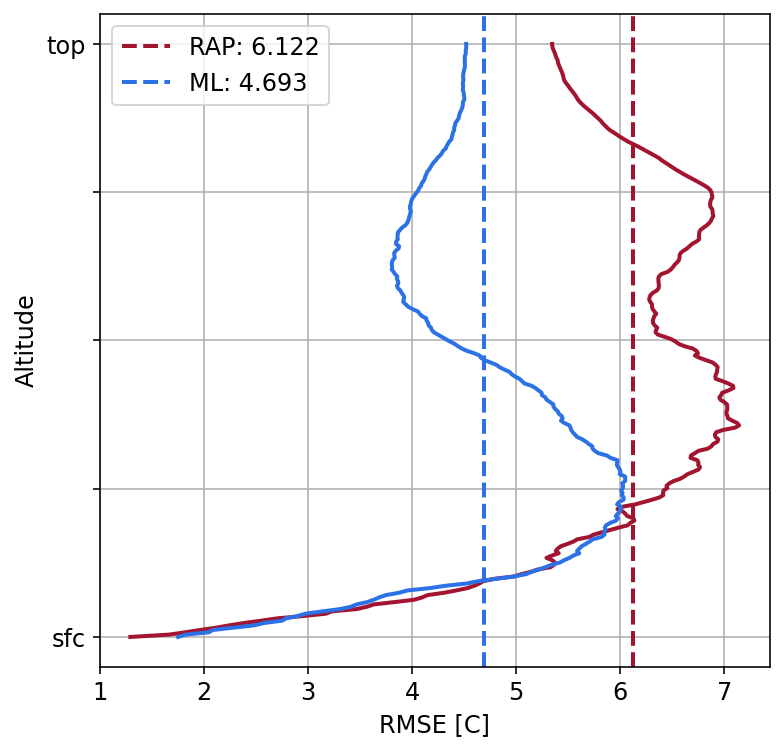

In [78]:
df = pd.read_csv(os.path.join(VOL, 'multi_cnn_model_temperature_dewpoint_regularization.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)
    
df.sort_values(['ml_temperature_test_mean_rmse']).head()

# UNet

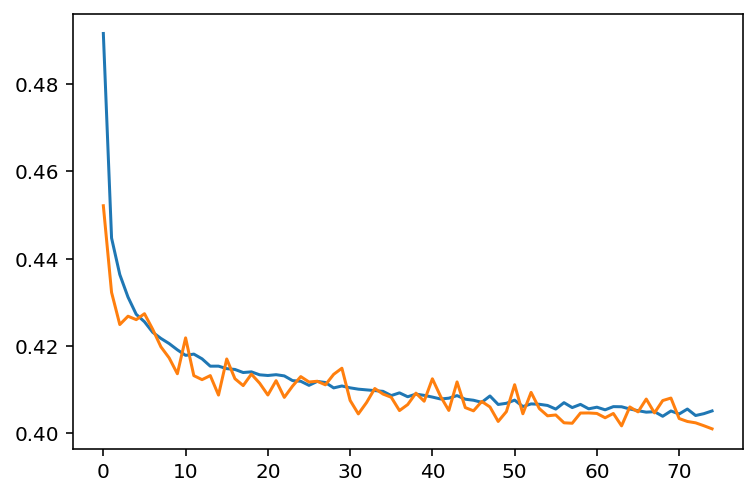

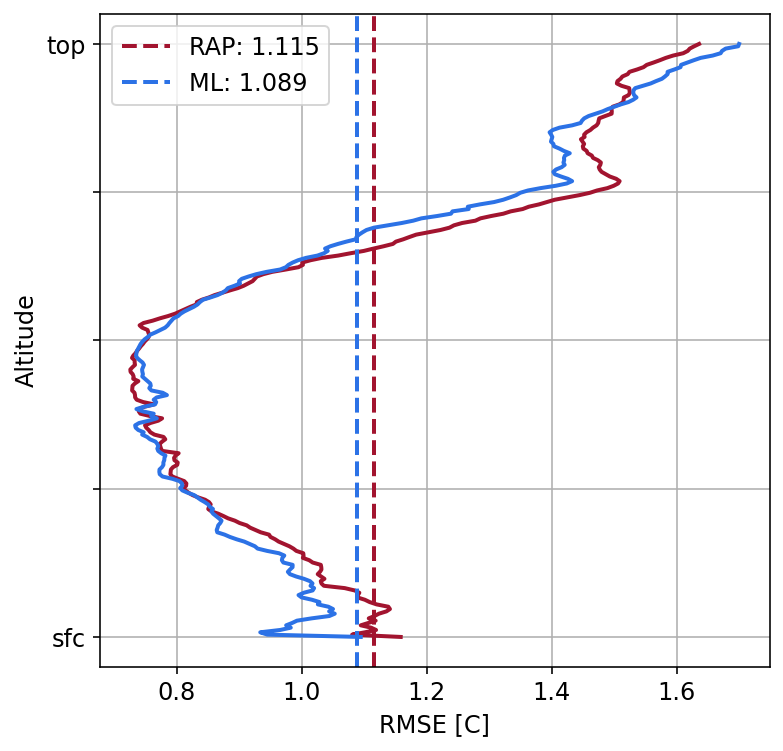

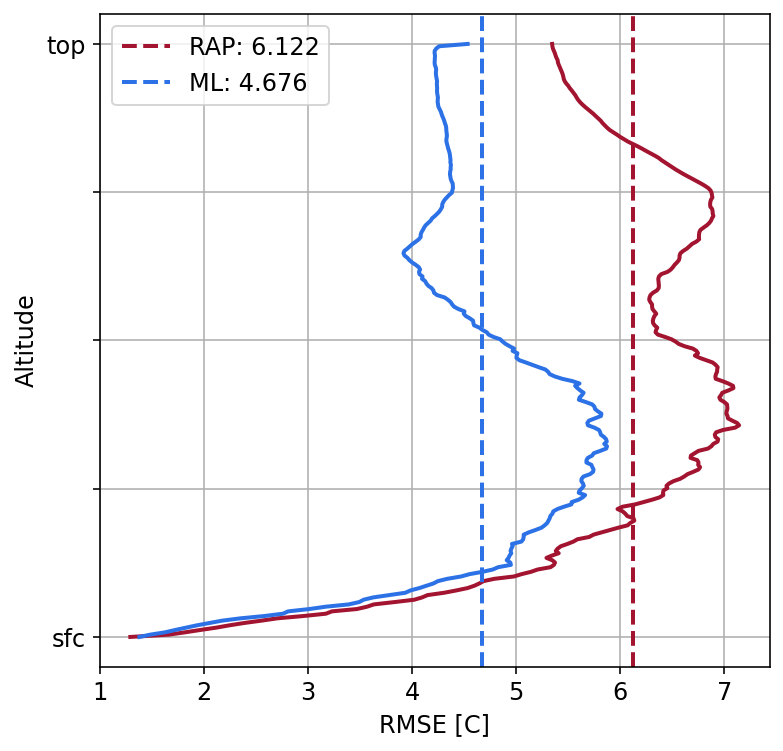

In [88]:
df = pd.read_csv(os.path.join(VOL, 'alley_skip_model_temperature_dewpoint.csv'))
# df = pd.read_csv(os.path.join(VOL, 'skip_model_temperature_dewpoint.csv'))

i = 47 # df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
data_set = 'test' # 'train'
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_{data_set}_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

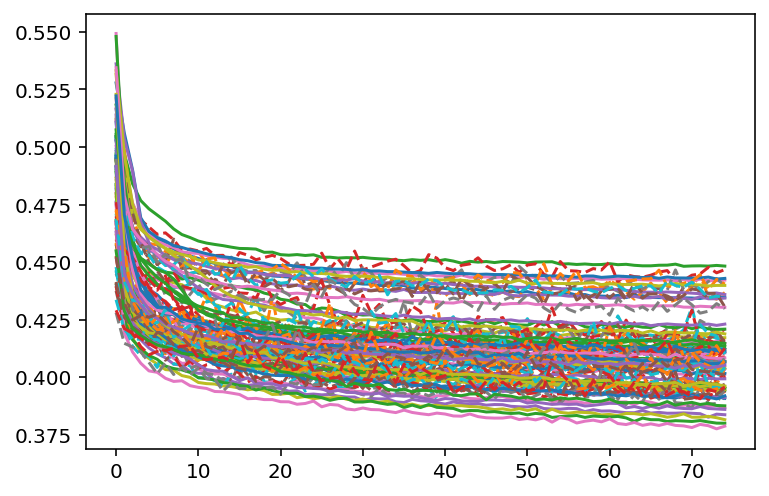

In [80]:
min_i, min_v, max_i, max_v = min_max(df)

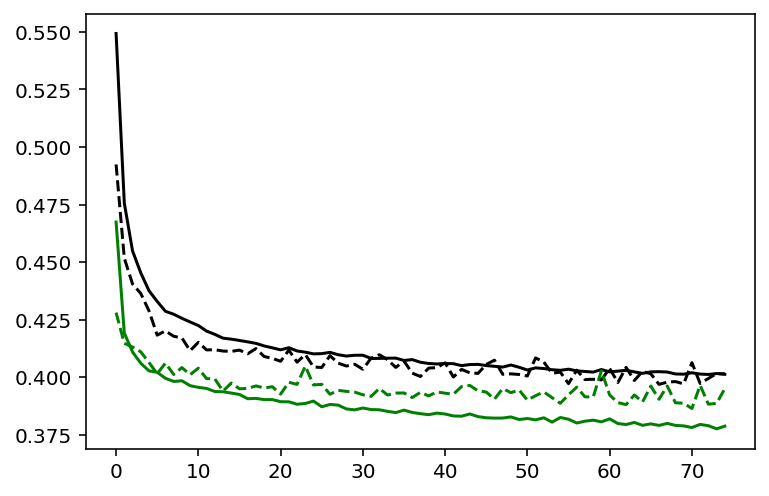

In [81]:
i = max_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'k')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--k')

i = min_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'g')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--g')

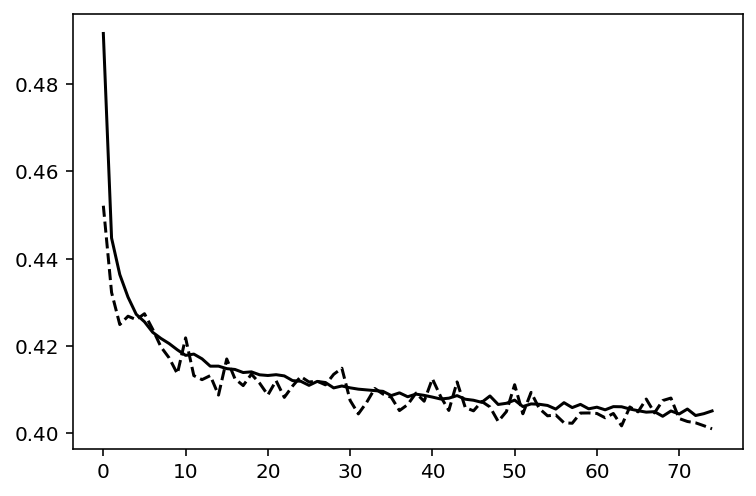

In [87]:
i = 47
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'k')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--k')

In [84]:
df[df['dropout'] == True].sort_values(['ml_temperature_test_mean_rmse']).head()

rap_input_dims rap_output_dims rtma_input_channels  \
15   [0, 1, 2, 3]          [1, 2]                  []   
23   [0, 1, 2, 3]          [1, 2]                  []   
47   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
27   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
19   [0, 1, 2, 3]          [1, 2]                  []   

         goes_input_channels n_rap_inputs n_im_inputs hiddens  \
15  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   
23  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   
47  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
27                        []     (256, 4)   (3, 3, 3)      []   
19  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   

    n_network_outputs       n_units_in_conv_layers kernels_size_and_stride  \
15                512            [32, 64, 128, 32]                  (3, 1)   
23                512  [32, 64, 128, 256, 512, 32]                  (3, 1)   
47                512  [32, 64, 128, 256, 512, 32]                  (3, 1)   
27                512            [32, 64, 128, 32]                  (3, 1)   
19                512     [32, 32, 32, 32, 32, 32]                  (3, 1)   

   rap_activation dense_activation optim      lr loss_f  n_epochs  batch_size  \
15           relu             relu  adam  0.0005    MAE        75         128   
23           relu             relu  adam  0.0005    MAE        75         128   
47           relu             relu  adam  0.0005    MAE        75         128   
27           relu             relu  adam  0.0005    MAE        75         128   
19           relu             relu  adam  0.0005    MAE        75         128   

    batchnorm  dropout                                               loss  \
15      False     True  [0.38381320238113403, 0.29880332946777344, 0.2...   
23      False     True  [0.42456501722335815, 0.3018530607223511, 0.28...   
47      False     True  [0.4507076144218445, 0.31177818775177, 0.29071...   
27      False     True  [0.3618836998939514, 0.29009389877319336, 0.27...   
19      False     True  [0.3557802140712738, 0.3006138801574707, 0.283...   

                              root_mean_squared_error  \
15  [0.49516570568084717, 0.43710821866989136, 0.4...   
23  [0.4798261821269989, 0.443284809589386, 0.4357...   
47  [0.49152159690856934, 0.44469743967056274, 0.4...   
27  [0.48176464438438416, 0.43931886553764343, 0.4...   
19  [0.5045660138130188, 0.4627537131309509, 0.444...   

                                   mean_squared_error  \
15  [0.24518908560276031, 0.19106359779834747, 0.1...   
23  [0.23023317754268646, 0.19650141894817352, 0.1...   
47  [0.24159345030784607, 0.19775579869747162, 0.1...   
27  [0.23209720849990845, 0.19300107657909393, 0.1...   
19  [0.2545868456363678, 0.21414099633693695, 0.19...   

                                  mean_absolute_error  \
15  [0.2931174039840698, 0.2559029161930084, 0.248...   
23  [0.2798921465873718, 0.25802183151245117, 0.25...   
47  [0.2897574305534363, 0.2591261863708496, 0.253...   
27  [0.2790651023387909, 0.25542789697647095, 0.25...   
19  [0.2937479019165039, 0.26750448346138, 0.25829...   

                                             val_loss  \
15  [0.309540331363678, 0.28356972336769104, 0.277...   
23  [0.31625860929489136, 0.2886402904987335, 0.27...   
47  [0.33197909593582153, 0.2941814959049225, 0.28...   
27  [0.2983223497867584, 0.2795790135860443, 0.270...   
19  [0.3112908899784088, 0.28566089272499084, 0.27...   

                          val_root_mean_squared_error  \
15  [0.4410303831100464, 0.420566201210022, 0.4232...   
23  [0.4449525475502014, 0.436524361371994, 0.4304...   
47  [0.45208609104156494, 0.4322482645511627, 0.42...   
27  [0.4413890540599823, 0.42870262265205383, 0.42...   
19  [0.47105705738067627, 0.44561538100242615, 0.4...   

                               val_mean_squared_error  \
15  [0.19450779259204865, 0.17687593400478363, 0.1...   
23  [0.19798277318477

In [82]:
df.sort_values(['ml_temperature_test_mean_rmse']).head()

rap_input_dims rap_output_dims rtma_input_channels  \
26   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
38   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
36   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
24   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
14   [0, 1, 2, 3]          [1, 2]                  []   

         goes_input_channels n_rap_inputs n_im_inputs hiddens  \
26                        []     (256, 4)   (3, 3, 3)      []   
38  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
36  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
24                        []     (256, 4)   (3, 3, 3)      []   
14  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   

    n_network_outputs n_units_in_conv_layers kernels_size_and_stride  \
26                512      [32, 64, 128, 32]                  (3, 1)   
38                512      [32, 64, 128, 32]                  (3, 1)   
36                512       [16, 32, 64, 16]                  (3, 1)   
24                512       [16, 32, 64, 16]                  (3, 1)   
14                512      [32, 64, 128, 32]                  (3, 1)   

   rap_activation dense_activation optim      lr loss_f  n_epochs  batch_size  \
26           relu             relu  adam  0.0005    MAE        75         128   
38           relu             relu  adam  0.0005    MAE        75         128   
36           relu             relu  adam  0.0005    MAE        75         128   
24           relu             relu  adam  0.0005    MAE        75         128   
14           relu             relu  adam  0.0005    MAE        75         128   

    batchnorm  dropout                                               loss  \
26      False    False  [0.3700491786003113, 0.29748210310935974, 0.28...   
38      False    False  [0.36242663860321045, 0.2921006679534912, 0.27...   
36      False    False  [0.332311749458313, 0.278271347284317, 0.26826...   
24      False    False  [0.33700457215309143, 0.28551724553108215, 0.2...   
14      False    False  [0.360446959733963, 0.29406625032424927, 0.279...   

                              root_mean_squared_error  \
26  [0.48900899291038513, 0.4381011426448822, 0.42...   
38  [0.46737560629844666, 0.41917699575424194, 0.4...   
36  [0.4837486147880554, 0.4244997799396515, 0.416...   
24  [0.4942137897014618, 0.4364902079105377, 0.425...   
14  [0.46816474199295044, 0.4280005693435669, 0.41...   

                                   mean_squared_error  \
26  [0.23912978172302246, 0.19193261861801147, 0.1...   
38  [0.2184399515390396, 0.17570935189723969, 0.16...   
36  [0.23401272296905518, 0.18020007014274597, 0.1...   
24  [0.24424728751182556, 0.1905236840248108, 0.18...   
14  [0.2191782146692276, 0.18318447470664978, 0.17...   

                                  mean_absolute_error  \
26  [0.28079572319984436, 0.25176215171813965, 0.2...   
38  [0.2701369524002075, 0.2434607744216919, 0.238...   
36  [0.2775036692619324, 0.24745814502239227, 0.24...   
24  [0.2829470634460449, 0.2528730034828186, 0.246...   
14  [0.2704583406448364, 0.24878865480422974, 0.24...   

                                             val_loss  \
26  [0.3120543956756592, 0.2887318432331085, 0.279...   
38  [0.30536338686943054, 0.2882106602191925, 0.27...   
36  [0.2930014431476593, 0.273521363735199, 0.2680...   
24  [0.2965981364250183, 0.2802703380584717, 0.273...   
14  [0.3085494339466095, 0.2851298153400421, 0.275...   

                          val_root_mean_squared_error  \
26  [0.45264318585395813, 0.4272227883338928, 0.42...   
38  [0.42805129289627075, 0.41471126675605774, 0.4...   
36  [0.43973156809806824, 0.4211658537387848, 0.41...   
24  [0.4465039372444153, 0.4269578158855438, 0.423...   
14  [0.4406130015850067, 0.42003026604652405, 0.41...   

                               val_mean_squared_error  \
26  [0.2048858404159546, 0.18251930177211761, 0.18...   
38  [0.18322789669036865, 0.1719854325056076, 0.17...   


# Best Model

In [29]:
from soundings.experiments import cnn_skip_neuralnetwork_driver as cnndriver

from soundings.deep_learning import tf_neuralnetwork as nn

In [30]:
data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)
rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = [0, 1, 2]
goes_input_channels = [0, 1, 2, 3, 4, 5, 6, 7]

driver = cnndriver.CNNSkipNetworkDriver()

Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                                                rtma_input_channels, goes_input_channels)

INFO: data organization - [0, 1, 2, 3] [1, 2] [0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
INFO: data dimensions - (19007, 256, 4) (19007, 3, 3, 11) (19007, 512) (2535, 256, 4) (2535, 3, 3, 11) (2535, 512) (3798, 256, 4) (3798, 3, 3, 11) (3798, 512)


In [31]:
n_hiddens_list = []
n_units_in_conv_layers = [4, 8, 16, 32, 64, 32]
kernels_size_and_stride = '(3, 1)'
rap_activation = 'relu'
dense_activation = 'relu'
optim = 'adam'
lr = 0.001
loss = 'MAE'
n_epochs = 15
batch_size = 128
dropout = False
batchnorm = False

n_rap_inputs = Xtr.shape[1:] # (256, 4)
n_im_inputs  = Xti.shape[1:] if Xti is not None else None # (3, 3, 3)
n_network_outputs = Tt.shape[1]

nnet = nn.SkipNeuralNetwork(n_rap_inputs, n_im_inputs, n_hiddens_list, n_units_in_conv_layers,
                            [literal_eval(kernels_size_and_stride)]* \
                                len(n_units_in_conv_layers), # all same size
                            n_network_outputs, rap_activation=rap_activation,
                            dense_activation=dense_activation, 
                            batchnorm=batchnorm, dropout=dropout)
nnet.model.summary()
nnet.train(Xtr, Xti, Tt, n_epochs, batch_size, method=optim, verbose=False,
           learning_rate=lr, validation=(Xvr, Xvi, Tv), loss_f=loss)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 4)       52          rap[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 4)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
skip_conv1d_0 (Conv1D)          (None, 256, 4)       52          activation[0][0]                 
_______________________________________________________________________________________

SkipNeuralNetwork(512)
  Final objective value is 0.23771 in 102.8893 seconds.

## Regional Errors

In [32]:
names_train = [f.split('_')[0] for f in FILEtrain]
names_val   = [f.split('_')[0] for f in FILEval]
names_test  = [f.split('_')[0] for f in FILEtest]

In [33]:
(np.unique(names_train, return_counts=True),
 np.unique(names_val, return_counts=True),
 np.unique(names_test, return_counts=True))

((array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
         'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
        dtype='<U3'),
  array([1093, 1054, 1047, 1048,  746, 1075, 1100, 1097, 1050, 1118, 1016,
         1088, 1047, 1056, 1125, 1114, 1060, 1073])),
 (array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
         'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
        dtype='<U3'),
  array([146, 141, 140, 140,  99, 143, 147, 146, 140, 149, 135, 145, 140,
         141, 150, 149, 141, 143])),
 (array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
         'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
        dtype='<U3'),
  array([218, 211, 209, 209, 149, 215, 219, 219, 210, 224, 203, 217, 209,
         211, 225, 223, 212, 215])))

In [34]:
locations = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df = pd.DataFrame.from_dict(locations).T
df = df.reset_index()
df.columns = ['location', 'lon', 'lat', 'indicies']
df.head(5)

location      lon    lat                                           indicies
0      abr   -98.42  45.45  [0, 15, 43, 56, 71, 91, 99, 104, 109, 175, 185...
1      ilx   -89.33  40.15  [1, 24, 47, 53, 59, 76, 115, 176, 184, 197, 22...
2      unr  -103.21  44.07  [2, 7, 9, 31, 33, 39, 66, 89, 94, 113, 116, 14...
3      fwd    -97.3   32.8  [3, 28, 40, 68, 69, 114, 133, 134, 137, 139, 1...
4      maf   -102.2  31.93  [4, 12, 19, 22, 65, 67, 111, 160, 193, 206, 23...

In [35]:
t_rmse  = []
td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    T_loc = T[inds]
    Y_loc = Y[inds]
    t_rmse.append(ml.rmse(T_loc[:,:,1], Y_loc[:,:,0]))
    td_rmse.append(ml.rmse(T_loc[:,:,2], Y_loc[:,:,1]))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse

In [36]:

def regional_error_map(df, count, title):
    fig = go.Figure(data=go.Scattergeo(
            locationmode = 'USA-states',
            lon = df['lon'],
            lat = df['lat'],
            text = df['location'],
            mode = 'markers',
            marker = dict(
                size = 6,
                opacity = 0.80,
                reversescale = True,
                autocolorscale = False,
                symbol = 'square',
                line = dict(
                    width=0.80,
                    color='rgba(75, 75, 75)'
                ),
                colorscale = 'ylorbr_r', # rdgy, viridis
                cmin = df[count].min(), # 0,
                color = df[count],
#                 cmax = df[count].max(),
#                 colorbar_title='',
#                 colorbar = dict(
#                     nticks = 10,
#                     len = 0.90,
#                     thickness = 10,
#                     ticks = 'outside',
#                     tickcolor = 'black',
#                     tickfont = dict(family='Arial', size=11, color='black'), # "Courier New", "Times New Roman"
#                     x = 0.90
#                 ),
            )
                   ))
    """
    ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
     'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
     'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
     'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
     'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
     'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
     'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
     'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
     'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
     'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
     'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
     'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
     'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
     'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
    """
    fig.update_layout(
            geo = dict(
                scope = 'usa',
                projection_type = 'albers usa',
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(100, 100, 100)",
                countrycolor = "rgb(100, 100, 100)",
                countrywidth = 0.5,
                subunitwidth = 0.5
            ), 
            margin=dict(l=0, r=0, t=0, b=5)
        )
    fig.show()

    fig.write_image(title, width=450, height=225, scale=4)

In [44]:
regional_error_map(df.iloc[[0]], 't_rmse', '/home/stock/research/media/dims/blank_map.png')

In [29]:
regional_error_map(df, 't_rmse', '/home/stock/research/media/temperature_error_bubble_map.png')

In [30]:
regional_error_map(df, 'td_rmse', '/home/stock/research/media/dewpoint_error_bubble_map.png')

## Error Distribution by Month

In [31]:
from soundings.plotting import radiosonde_plotting

In [32]:
samples = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    month = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    if month in samples:
        arr = samples[month][0]
        arr.append(i)
        samples[month] = [arr]
    else:
        samples[month] = [[i]]
        
df = pd.DataFrame.from_dict(samples).T
df = df.reset_index()
df.columns = ['month', 'indicies']

df = df.sort_values('month')
df.head(5)

month                                           indicies
7      1  [30, 31, 36, 39, 47, 52, 58, 64, 69, 122, 128,...
4      2  [4, 7, 9, 19, 25, 28, 40, 50, 60, 80, 86, 88, ...
1      3  [1, 6, 10, 12, 24, 26, 27, 37, 51, 74, 79, 81,...
2      4  [2, 11, 17, 22, 29, 41, 44, 57, 77, 84, 85, 95...
3      5  [3, 8, 14, 21, 23, 33, 38, 42, 55, 62, 65, 71,...

In [33]:
t_rmse  = []
td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    # sqrt of the mean difference between each vertical level (256,)
    t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - Y[inds,:,0])**2, axis=0)))
    td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - Y[inds,:,1])**2, axis=0)))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse

In [34]:
df.head()

month                                           indicies  \
7      1  [30, 31, 36, 39, 47, 52, 58, 64, 69, 122, 128,...   
4      2  [4, 7, 9, 19, 25, 28, 40, 50, 60, 80, 86, 88, ...   
1      3  [1, 6, 10, 12, 24, 26, 27, 37, 51, 74, 79, 81,...   
2      4  [2, 11, 17, 22, 29, 41, 44, 57, 77, 84, 85, 95...   
3      5  [3, 8, 14, 21, 23, 33, 38, 42, 55, 62, 65, 71,...   

                                              t_rmse  \
7  [1.599128144741435, 1.2222650734528269, 1.0655...   
4  [1.0529715109956772, 1.2187584469773913, 1.082...   
1  [1.110889668081065, 1.046681606879093, 0.90253...   
2  [1.112114996793509, 1.034831319777222, 0.85308...   
3  [1.0896782248136896, 0.9358529706934031, 0.898...   

                                             td_rmse  
7  [1.5718805287074769, 1.4436620694752842, 1.354...  
4  [1.3181688899668753, 1.7887239486629425, 1.823...  
1  [1.9840599042752523, 1.5623252921283282, 1.630...  
2  [1.2136371561807267, 1.4622473843828523, 1.536...  
3  [1.247583296081733, 1.436798799466462, 1.57380...

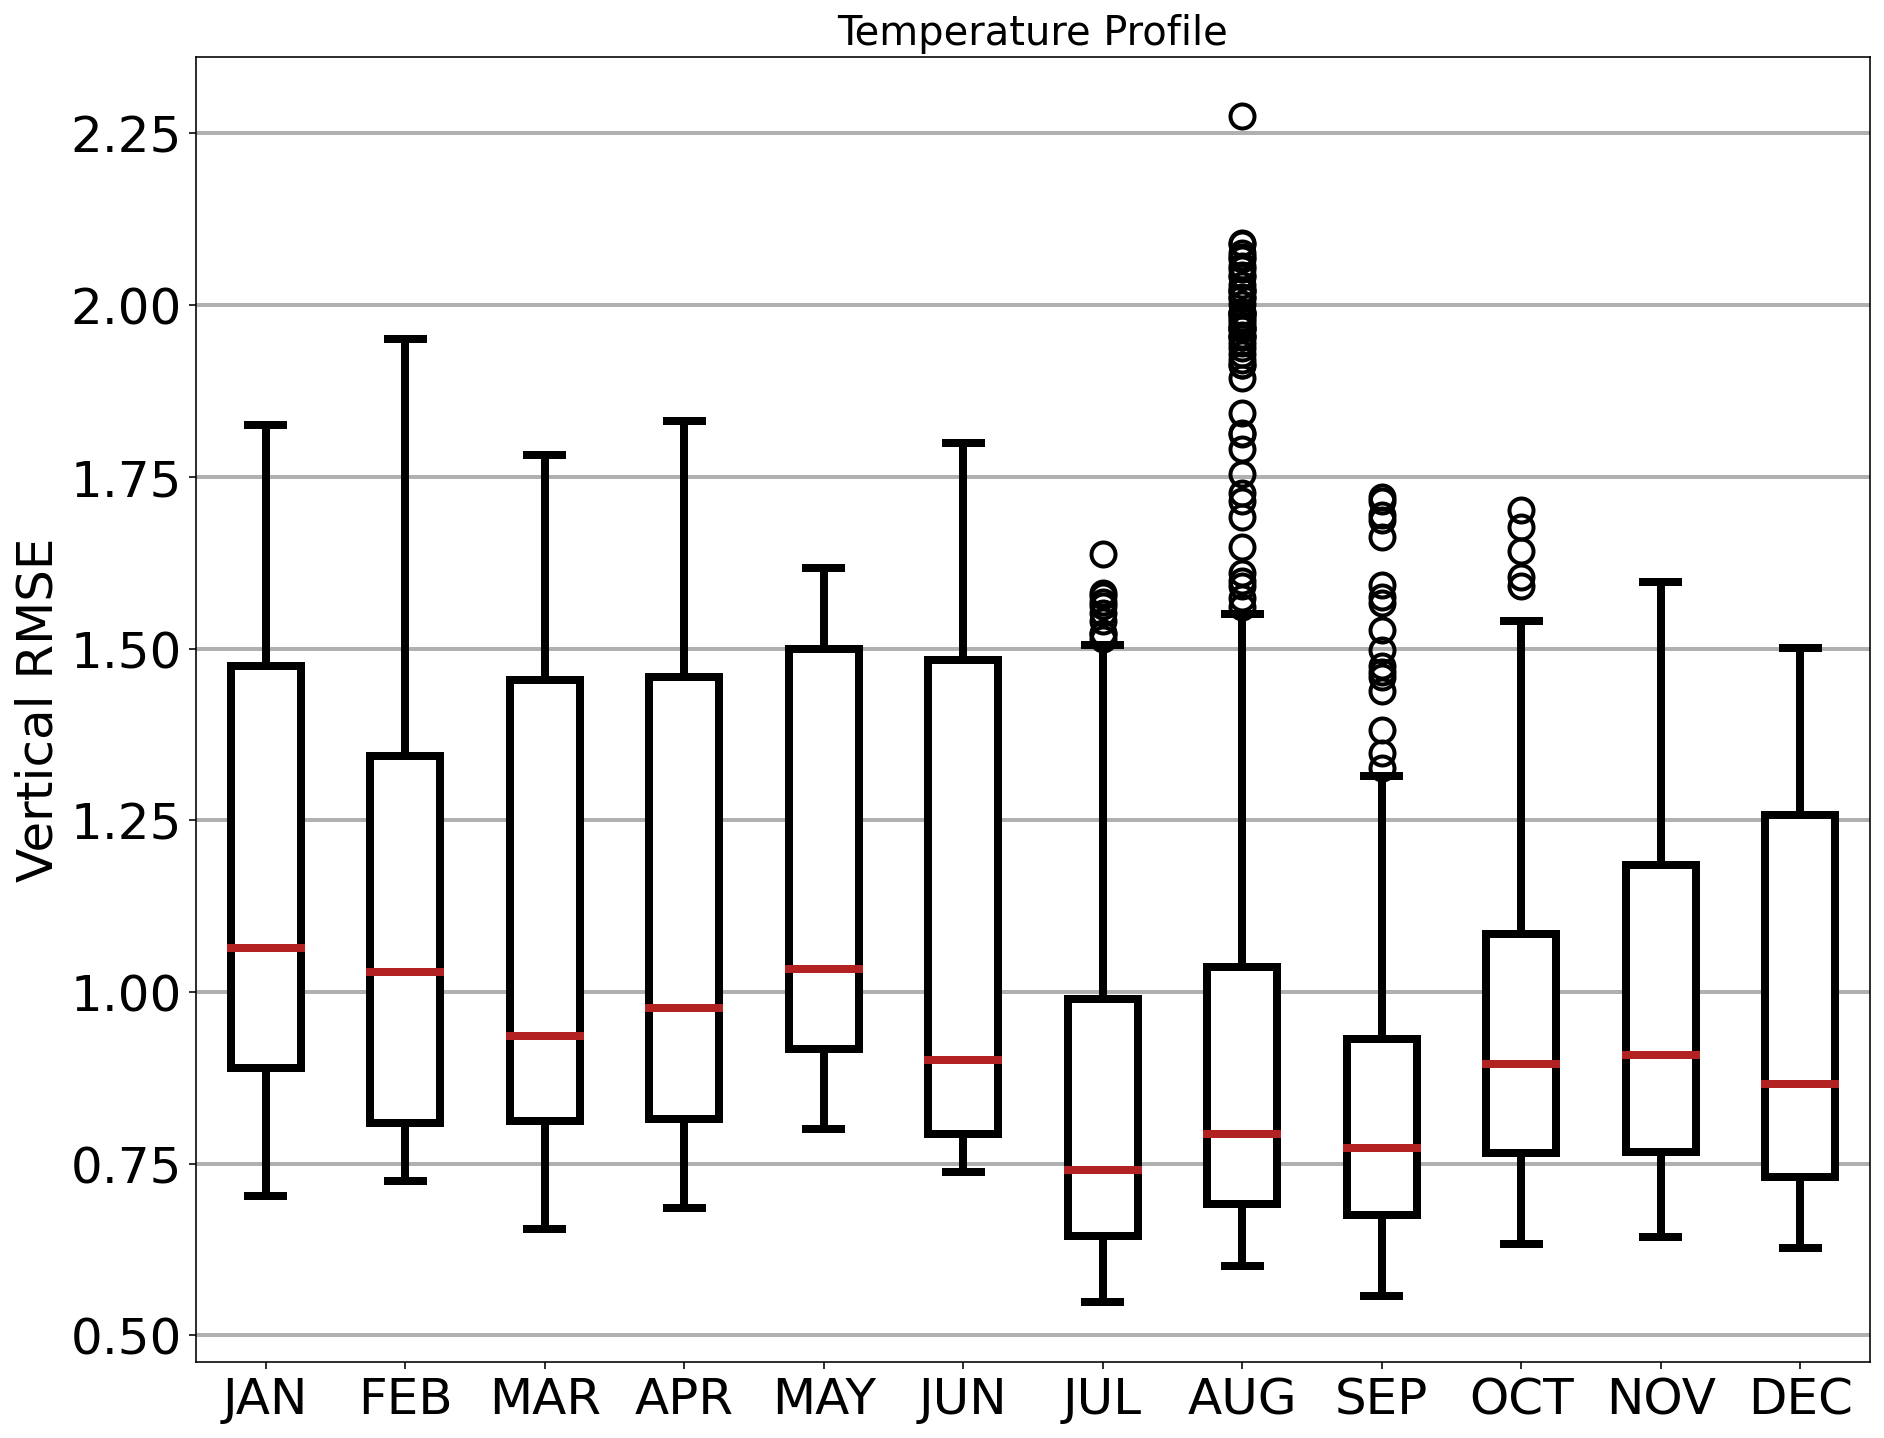

In [35]:
radiosonde_plotting.plot_monthly_error(df['t_rmse'].values, df['month'].values, 'Temperature Profile', 
                                       file_name='/home/stock/research/media/temperature_monthly_error.png');

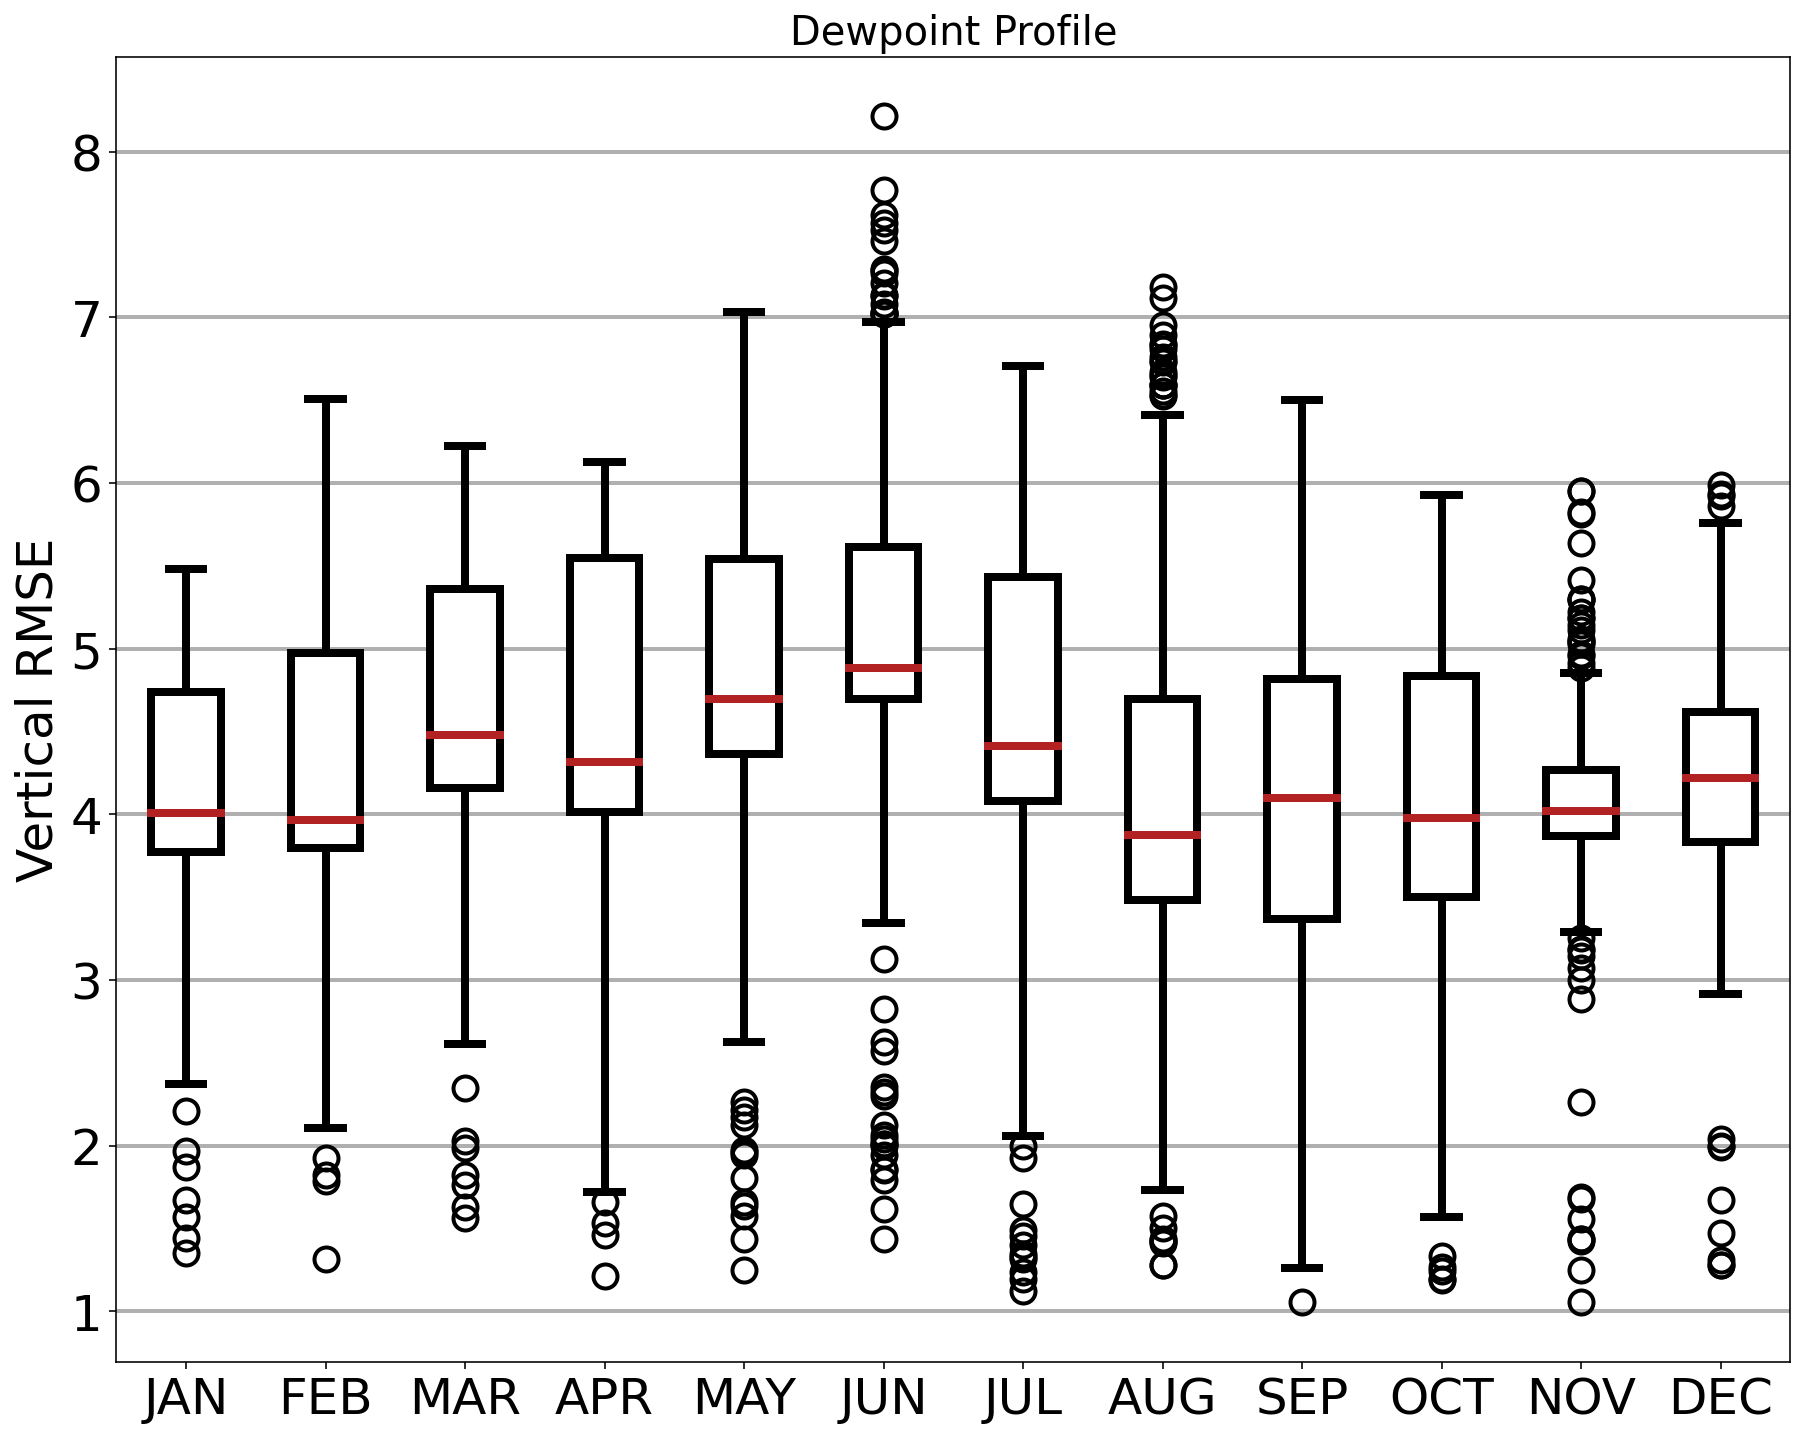

In [36]:
radiosonde_plotting.plot_monthly_error(df['td_rmse'].values, df['month'].values, 'Dewpoint Profile',
                                       file_name='/home/stock/research/media/dewpoint_monthly_error.png');